## Eyes - Detección y posicionamiento

Visión por Computadora 1 - TP3

Para la imagen suministrada eyes (por ninguna razón en especial, con heterocromía), implementar un algoritmo que **encuentre la posición** de:
1. los iris en cada par de ojos y mida su **distancia** en píxeles
2. las pupilas en cada par de ojos y mida su **distancia** en píxeles

In [1]:
import numpy as np
import cv2 as cv
#from skimage.util import random_noise
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = ['eyes.jpg']
img = cv.imread(files[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

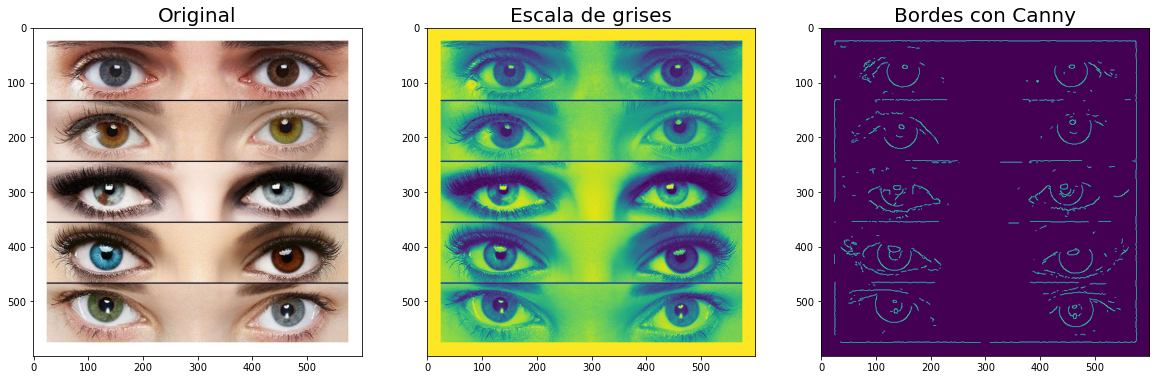

In [3]:
# aplico suavizado con la mediana o uno gausiano orientado a targetear círculos
# blur = difuminado
medianBl = cv.medianBlur(gray, 5)
#gaussianBl = cv.GaussianBlur(gray, (5,5),0)
#gaussianBl3 = cv.GaussianBlur(gray, (5,5),7)
#LoG = medianBl - gaussianBl3

# Canny
#img_bordes = cv.Canny(img, 30, 180, L2gradient=True)
#img_bordes = cv.Canny(img, 150, 160, L2gradient=True, apertureSize=3) # apertura [3, 5, 7]
img_bordes = cv.Canny(medianBl, 150, 160, L2gradient=True, apertureSize=3) # apertura [3, 5, 7]

fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(img[:,:,::-1])
ax2.imshow(gray)
ax3.imshow(img_bordes, vmin=0, vmax=255)

ax1.set_title('Original', fontsize=20)
ax2.set_title('Escala de grises', fontsize=20)
ax3.set_title('Bordes con Canny', fontsize=20)

plt.show();

Dado que algunos iris no responden a un círculo claro, se pueden generar errores u omisiones en la detección (inferencia). Esto se confirma tras haber corrido Canny y la transformada de Hough con distintos parámetros. Algo similar ocurre con la pupila, dado que en algunos segmentos se confunden con el reflejo de la luz. Para produndizar sobre el tema, se podría probar correr **template matching** en instancias previas a la transformada de Hough. 

In [4]:
img_bordes.shape

(600, 600)

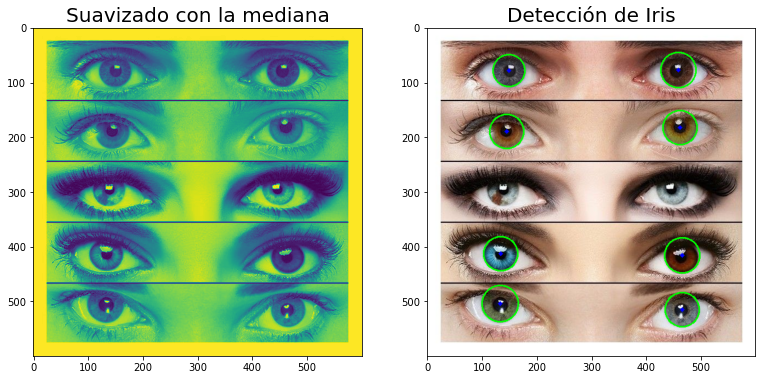

In [5]:
# transformada de Hough para detectar IRIS, con siguientes parámetros
#       1. imagen en grises (en este caso, tb suavizada)
#       2. método,
#       3. flag de resolución del acumulador,
#       4. dist mín entre centros de círculos,
#       5. umbral alto de Canny,
#       6. umbral del acumulador,
#       7. radio_min,
#       8. radio_max,

img_circles = img.copy()

# al pasarle img_bordes solo detecta 1 iris...
circles = cv.HoughCircles(medianBl, 
                          cv.HOUGH_GRADIENT, 1.1, minDist=50,
                          param1=40, param2=35, minRadius=21, maxRadius=35)

circles = np.uint16(np.around(circles)) # conversión
for i in circles[0,:]:
    cv.circle(img_circles, (i[0],i[1]), i[2], (0,255,0), 2) # IRIS - círculos externos sobre imagen original
    cv.circle(img_circles, (i[0],i[1]), 2, (255,0,0), 3) # centro de los círculos externos sobre imagen original

fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)

ax1.imshow(gray)
ax2.imshow(img_circles[:,:,::-1])

ax1.set_title('Suavizado con la mediana', fontsize=20)
ax2.set_title('Detección de Iris', fontsize=20)

plt.show();

In [6]:
flags = [i for i in dir(cv) if i.startswith('HOUGH_')]
print(flags) # de todos modos, solo la primera implementada

['HOUGH_GRADIENT', 'HOUGH_GRADIENT_ALT', 'HOUGH_MULTI_SCALE', 'HOUGH_PROBABILISTIC', 'HOUGH_STANDARD']


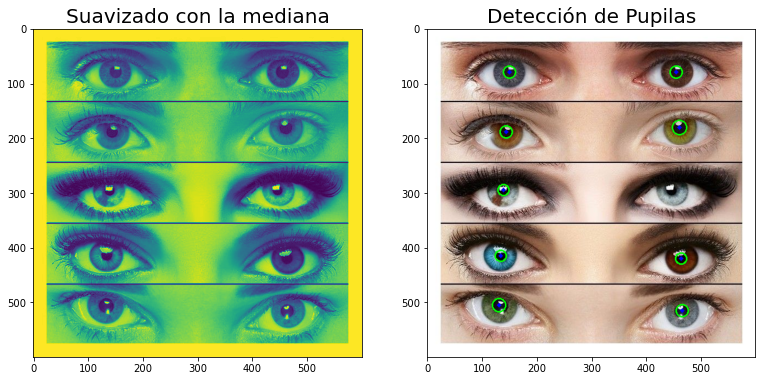

In [7]:
# suavizado  + transformada de Hough para detectar PUPILAS
medianBl = cv.medianBlur(gray, 7)

img_circles2 = img.copy()
circles2 = cv.HoughCircles(medianBl, 
                          cv.HOUGH_GRADIENT, 1.1, minDist=70,
                          param1=80, param2=22, minRadius=8, maxRadius=18)

circles2 = np.uint16(np.around(circles2)) # conversión

for i in circles2[0,:]:
    # circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
    cv.circle(img_circles2, (i[0],i[1]), i[2], (0,255,0), 2) # Pupilas - círculos externos sobre imagen original
    cv.circle(img_circles2, (i[0],i[1]), 2, (255,0,0), 3) # centro de los círculos externos sobre imagen original

fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)

ax1.imshow(gray)
ax2.imshow(img_circles2[:,:,::-1])

ax1.set_title('Suavizado con la mediana', fontsize=20)
ax2.set_title('Detección de Pupilas', fontsize=20)

plt.show();

* circles, img_circles -> IRIS
* circles2, img_circles2 -> PUPILAS

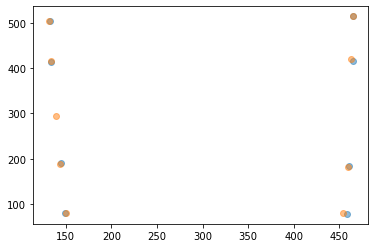

In [8]:
plt.scatter(circles.T[0], circles.T[1], alpha=.5);
plt.scatter(circles2.T[0], circles2.T[1], alpha=.5);

A indagar:
- Se pueden inferir los iris a partir de las pupilas?
- y los iris/pupilas restantes a partir de inferencia más generalizada?

In [9]:
# circles -> val_x, val_y, radio
c = [circles, circles2]
out = [img_circles, img_circles2]

for z,k in zip(c, out):
    index_x = np.argsort(z[0,:,0])
    index_y = np.argsort(z[0,:,1])
    par_2d = z[0,(index_y),1]//100
    diff = np.vstack((z[0, index_y,0], par_2d))
    
    distance = []
    for i in diff[1,:]:
        distance.append(diff[0,diff[1,:]==i].max() - diff[0,diff[1,:]==0].min())
    
    a = np.array([z[0, index_y,0], z[0, index_y,1], distance])
    x1 = a[0,:][a[0]<200]
    y1 = a[1,:][a[0]<200]
    x2 = a[0,:][a[0]>200]
    y2 = a[1,:][a[0]>200]
    dist = a[2,:][a[0]<200]
    
    left = [ (i,j) for i,j in zip(a[0,:][a[0]<200],a[1,:][a[0]<200])]
    right = [ (i,j) for i,j in zip(a[0,:][a[0]>200], a[1,:][a[0]>200])]
    number = [ (260,i-15) for i in a[1,:][a[0]>200]]
    
    output = k.copy()
    for i,j,l,m in zip(left, right, number, dist):
        output = cv.line(output, i, j, (0, 255, 0), 2, cv.LINE_AA) # línea suavizada
        output = cv.putText(output, str(m)+'px', l, cv.FONT_ITALIC, 1, (0,100,0), 2)
        out.append(output)        

<ipython-input-9-d26f8c1d7206>:13: RuntimeWarning: overflow encountered in ushort_scalars
  distance.append(diff[0,diff[1,:]==i].max() - diff[0,diff[1,:]==0].min())


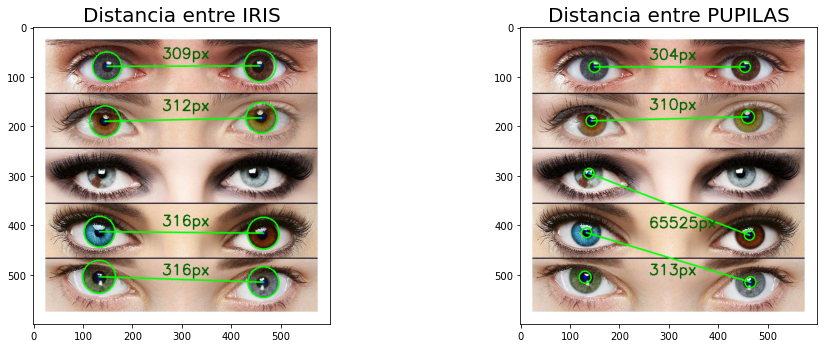

In [10]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)

ax1.imshow(out[2][:,:,::-1], vmin=0, vmax=255)
ax2.imshow(out[-1][:,:,::-1], vmin=0, vmax=255)

ax1.set_title('Distancia entre IRIS', fontsize=20)
ax2.set_title('Distancia entre PUPILAS', fontsize=20)

plt.show();

Por delante queda corregir la detección y/o la vinculación del 3er par de IRIS y PUPILAS para que los 2 últimos pares se alínen en la presentación de distancias.

In [11]:
# para ver alternativas
flags1 = [i for i in dir(cv) if i.startswith('LINE_')]
flags2 = [i for i in dir(cv) if i.startswith('FONT_')]
print(flags1, flags2) 

['LINE_4', 'LINE_8', 'LINE_AA'] ['FONT_HERSHEY_COMPLEX', 'FONT_HERSHEY_COMPLEX_SMALL', 'FONT_HERSHEY_DUPLEX', 'FONT_HERSHEY_PLAIN', 'FONT_HERSHEY_SCRIPT_COMPLEX', 'FONT_HERSHEY_SCRIPT_SIMPLEX', 'FONT_HERSHEY_SIMPLEX', 'FONT_HERSHEY_TRIPLEX', 'FONT_ITALIC']
